In [4]:
!pip install tensorflow --timeout=600

In [13]:
pip install --upgrade tensorflow tensorflow-hub

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1


Found 200 validated image filenames belonging to 10 classes.
Found 50 validated image filenames belonging to 10 classes.
Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/10


C:\Users\HP\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.2473 - loss: 3.7892 - val_accuracy: 0.5800 - val_loss: 1.2836
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7359 - loss: 1.0879 - val_accuracy: 0.8000 - val_loss: 0.7629
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8488 - loss: 0.5343 - val_accuracy: 0.8600 - val_loss: 0.5246
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9044 - loss: 0.3157 - val_accuracy: 0.8000 - val_loss: 0.6079
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7882 - loss: 0.3821 - val_accuracy: 0.8000 - val_loss: 0.4589
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8992 - loss: 0.3535 - val_accuracy: 0.8400 - val_loss: 0.2795
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8954 - loss: 0.2829 - val_accuracy: 0.8400 - val_loss: 0.4077
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9071 - loss: 0.2599 - val_accuracy: 0.8800 - val_loss: 0.5649
Epoch 9/10
7/7 ━━━━

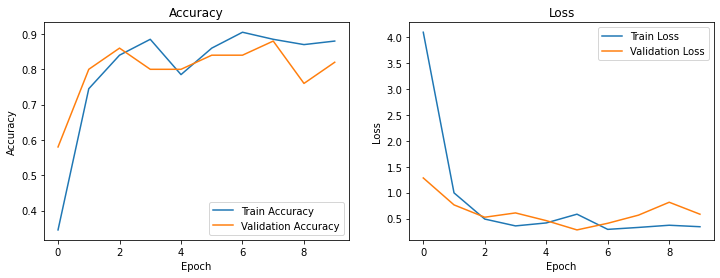

In [52]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage

# Constants
DATASET_PATH = "C:/Users/HP/colour training_dataset"  # Path to the dataset
LABELS_CSV_PATH = "colour-labels.csv"  # Path to the CSV file

# Load labels from the CSV file
labels_df = pd.read_csv(LABELS_CSV_PATH)

# Convert 'colour' column to string
labels_df['colour'] = labels_df['colour'].astype(str)

# Prepare the image paths and labels
image_paths = []
labels = []

# Iterate through the labels DataFrame to gather paths and labels
for _, row in labels_df.iterrows():
    image_name = row['id'] + '.png'  # Append .png since images are in PNG format
    color_label = row['colour']  # Get the corresponding color label
    image_path = os.path.join(DATASET_PATH, color_label, image_name)  # Construct the full path
    
    if os.path.exists(image_path):  # Check if the image exists
        image_paths.append(image_path)
        labels.append(color_label)
    else:
        print(f"Image not found: {image_path}")  # Print a message if the image is not found

# Check if there are any valid image paths
if len(image_paths) == 0:
    raise ValueError("No valid image paths found. Check your dataset.")

# Encode labels into integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)

# Set image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224  # Adjust based on your model's requirements

# Create data generators for image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators for the training and validation sets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Model Configuration
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
OUTPUT_SHAPE = len(label_encoder.classes_)

# Setting up the Model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

from tensorflow.keras import layers, models

# Creating the Function to build the Keras model
def create_model():
    print("Building model with:", MODEL_URL)

    # Create the model without using Sequential
    model = models.Sequential()
    model.add(layers.Input(shape=(224, 224, 3)))  # Example input shape for image data
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"]
    )

    return model

model = create_model()

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Making predictions
predictions = model.predict(val_generator)

# Visualizing training results (loss & accuracy)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


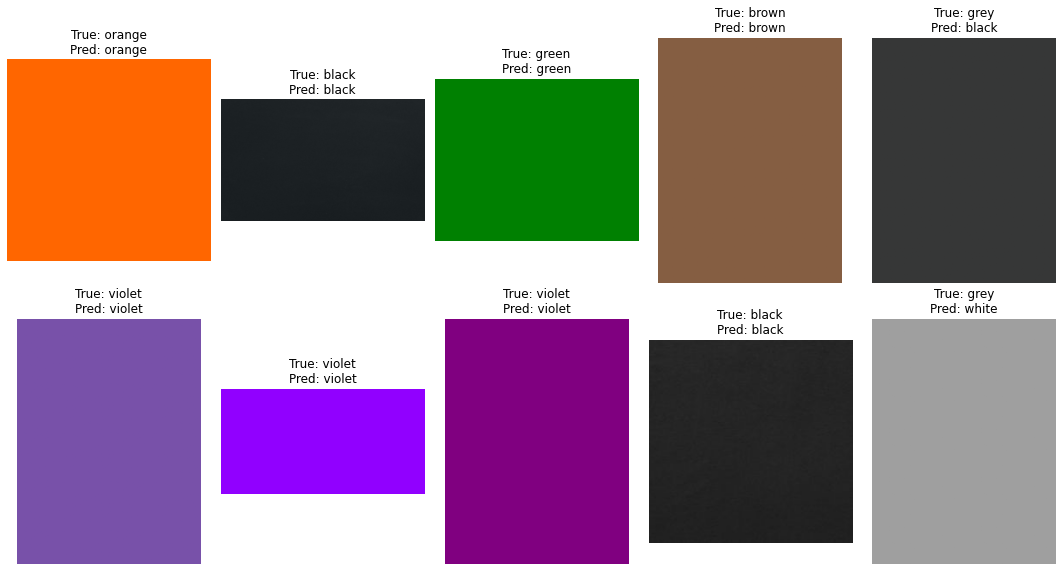

In [53]:
predictions = model.predict(val_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels from the validation generator
true_classes = val_generator.classes

# Get class labels as strings from the encoder
class_labels = label_encoder.inverse_transform(predicted_classes)

# Visualize some predictions
def plot_predictions(image_paths, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 8))
    
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)
        img = plt.imread(image_paths[i])
        plt.imshow(img)
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot predictions
plot_predictions(val_paths[:10], val_labels[:10], class_labels[:10])  # Plot the first 10 predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


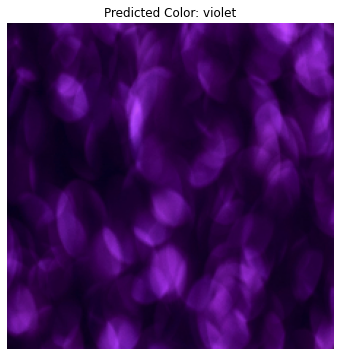

The predicted color for the image is: violet


In [63]:
from tensorflow.keras.preprocessing import image

# Function to load and predict the color of an image
def load_and_predict_image(image_path, model, label_encoder):
    # Load the image
    img = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)) 
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Normalize the image data
    img_array = img_array / 255.0
    
    # Expand dimensions to match the model input shape
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    
    # Make a prediction
    predictions = model.predict(img_array)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(predictions, axis=1)
    
    # Map the predicted index back to class label
    predicted_class_label = label_encoder.inverse_transform(predicted_class_index)
    
    # Display the image and prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted Color: {predicted_class_label[0]}")
    plt.axis('off')  # Hide axes
    plt.show()

    return predicted_class_label[0]  # Return the label

# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\colour-test-data.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


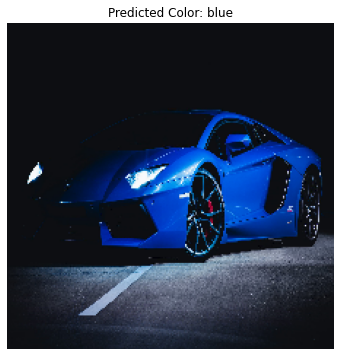

The predicted color for the image is: blue


In [66]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\blue-car.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


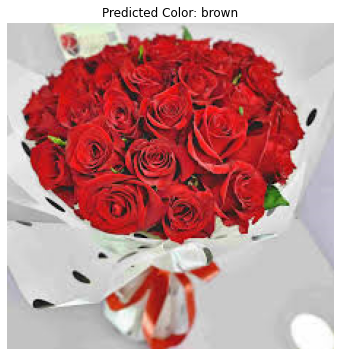

The predicted color for the image is: brown


In [67]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\red-rose.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


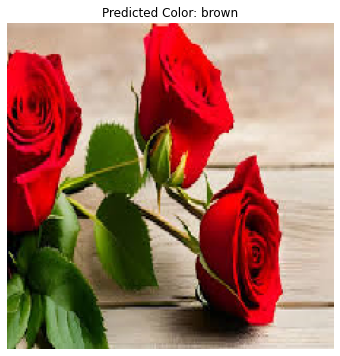

The predicted color for the image is: brown


In [68]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\red-roses.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step


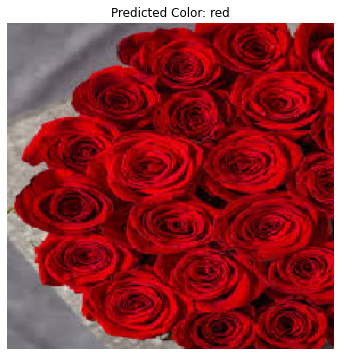

The predicted color for the image is: red


In [69]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\roses.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


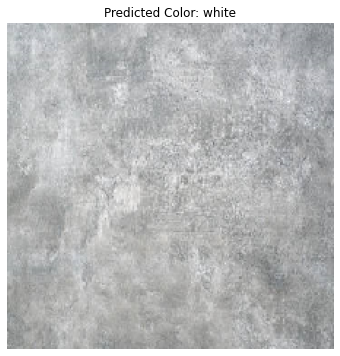

The predicted color for the image is: white


In [70]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\grey-sample.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


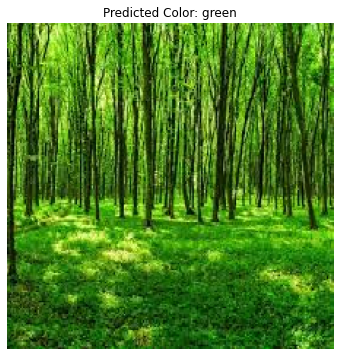

The predicted color for the image is: green


In [71]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\green-trees.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


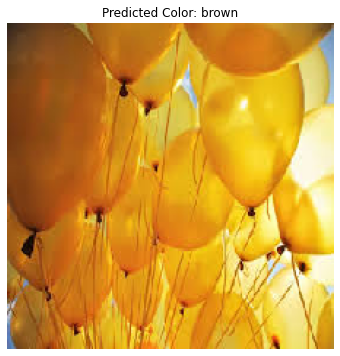

The predicted color for the image is: brown


In [72]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\yellow-balloons.png"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


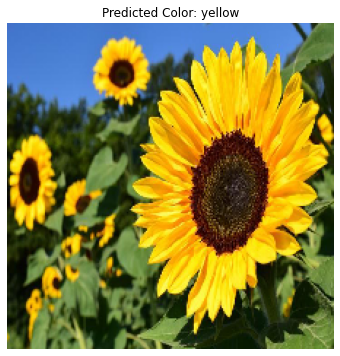

The predicted color for the image is: yellow


In [73]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\sunflower.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


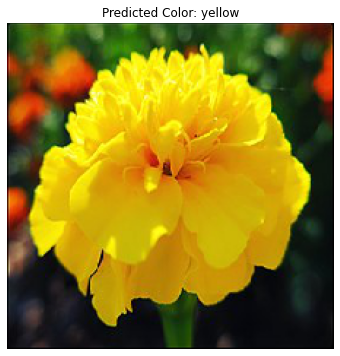

The predicted color for the image is: yellow


In [74]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\yellow-flower.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


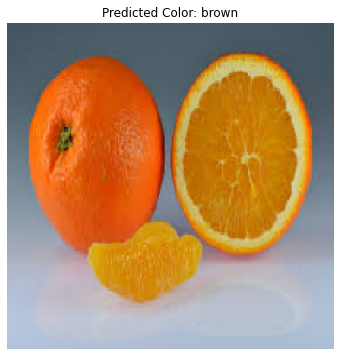

The predicted color for the image is: brown


In [75]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\oranges.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


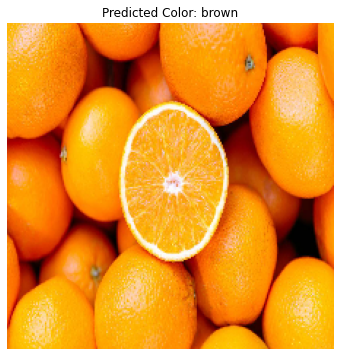

The predicted color for the image is: brown


In [76]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\oranges1.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


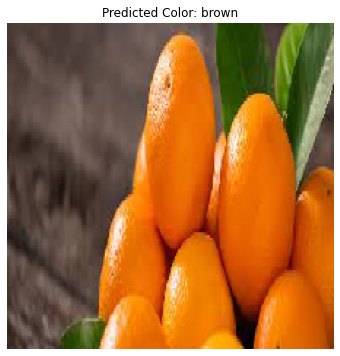

The predicted color for the image is: brown


In [77]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\oranges2.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


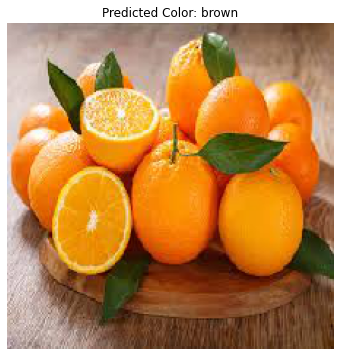

The predicted color for the image is: brown


In [78]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\oranges3.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step


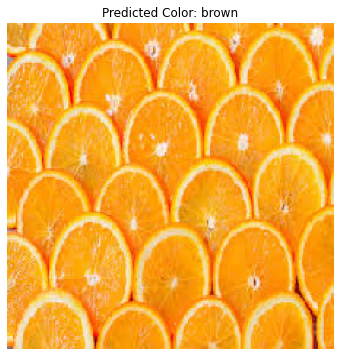

The predicted color for the image is: brown


In [79]:
# Path to the test image
test_image_path = r"C:\Users\HP\colour test_dataset\oranges4.jpg"

# Make a prediction
predicted_label = load_and_predict_image(test_image_path, model, label_encoder)

# Output the prediction
print(f"The predicted color for the image is: {predicted_label}")